# CIFAR with CNN

The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.


The CIFAR dataset is similar to MNIST, except that instead of grayscale, there are three color channels (RGB).<br>
The size of MNIST is (1,28,28), while CIFAR has (3,32,32) images.
There are 10 categories to classify an image:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

##Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Load the CIFAR dataset
The CIFAR train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. When we use datasets.CIFAR10, CIFAR dataset will be downloaded on personal your computer. <br>The set contains 50,000 train and 10,000 test images.

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Load data using DataLoader

In [ ]:
torch.manual_seed(101)  #reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels
We can call the labels 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. We're using 5-character labels padded with spaces.

In [ ]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

## Show a batch of images

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


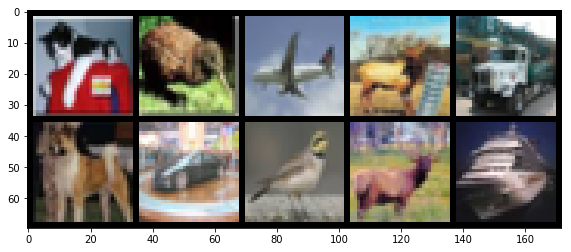

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array


for images,labels in train_loader: 
    break


print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5) 
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model
We'll use the following layers of CNN for the model.
1. Two convolutional layers.
2. Two pooling layers
3. Feeding data through a fully connected hidden layer to our output. 
So we have: CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC. 

First convolutional layer will have 3 input channels (color), 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in to initializer.

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'\n{sum(params):>6}')

In [ ]:
count_parameters(model)

## Loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.<br>
Here is where a GPU needed. Training CNN for CIFAR dataset takes too long and GPU helps to speed up the running time.


In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.72811735  accuracy:  26.660%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.90085292  accuracy:  32.790%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.77626872  accuracy:  36.507%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.32156026  accuracy:  38.925%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.37019920  accuracy:  40.922%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.18819773  accuracy:  51.520%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.21327436  accuracy:  51.725%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.15835631  accuracy:  52.283%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.28492486  accuracy:  52.587%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 2.28428698  accuracy:  52.930%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.22954726  accuracy:  56.750%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.51806808  accuracy:  56.725%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.82857972  accuracy:  56.847%
epoch:  2  b

In [ ]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

## Plot the loss and accuracy for training and validation set

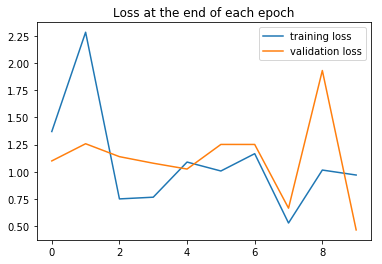

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

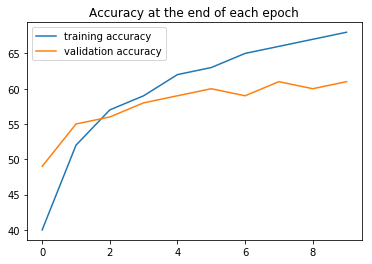

In [ ]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate the model on unseen data

In [ ]:
print(test_correct) 
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') 

[tensor(4940), tensor(5519), tensor(5685), tensor(5812), tensor(5930), tensor(6048), tensor(5941), tensor(6166), tensor(6035), tensor(6105)]

Test accuracy: 61.050%


We would have to paly with parameters to obtain better results.<br>
Still, it's much better than the random guess!

## Display the confusion matrix

Confusion matrix helps us to display results and make the model better.

In [ ]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label.

In [ ]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
len(misses)

3895

In [ ]:
misses[:8]

array([    3,     4,     6,     7,     8,    17,    20,    21],
      dtype=int64)

In [ ]:
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Run the cell below to view all of the missed predictions.

Index: [    3     4     6     7     8    17    20    21]
Label: [    0     6     1     6     3     7     7     0]
Class:  plane  frog   car  frog   cat horse horse plane

Guess: [    8     4     2     4     5     3     2     2]
Class:   ship  deer  bird  deer   dog   cat  bird  bird


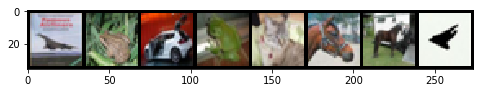

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Now you did multi-class classification for CIFAR dataset.